In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

import itertools
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 600)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
#import swifter

np.random.seed(1907)

In [2]:
def initial_data_preparation():
    

    data = pd.read_csv("../data/interim/spark_processed_data.csv", sep="|")

    
    
    print(f"{len(data)} Rows.")
   

    multi_choice_columns = pd.read_csv("../data/interim/spark_multi_choice_columns.csv", sep="|")["0"].tolist()
    data = data.drop(multi_choice_columns, axis=1)
    
    #Outlier Handling
    # Age 90'dan büyükse sil
    data = data[data["Age"] <90]
    # WorkWeekHrs drop
    data = data.drop("WorkWeekHrs", axis=1)
    

    
    # Preserve country columns for target transformation
    data["Country_for_target_transformation"] = data["Country"]
    
    #Drop observations have less then $100 ConvertedComp and professional dev.
    data = data[(~(data["ConvertedComp"]<100) &  (data.MainBranch == "I am a developer by profession"))]

    #Drop observations have greater then $0.5M ConvertedComp
    data = data[data["ConvertedComp"]<=500000]
    
    #Use the data only from professional developers
    data = data[data.MainBranch == "I am a developer by profession"]
    
    # One hot encoding
    cat_columns = ["Country", "Gender", "JobSat", 
                                        "JobSeek",
                                        "Employment",
                                        "MainBranch", 
                                        "Hobbyist", 
                                        "EdLevel", 
                                        "NEWDevOps", 
                                        "NEWDevOpsImpt", 
                                        "NEWEdImpt", 
                                        "NEWLearn",
                                        "NEWOffTopic",
                                        "NEWOnboardGood",
                                        "NEWOtherComms",
                                        "NEWOvertime",
                                        "NEWPurpleLink","OpSys","OrgSize",
                                        "PurchaseWhat","SOAccount",
                                        "SOComm","SOPartFreq","SOVisitFreq",
                                        "SurveyEase", "SurveyLength","Trans", "UndergradMajor","WelcomeChange"]
    
    cat_columns = [col for col in cat_columns if col not in multi_choice_columns]
    data = pd.get_dummies(data=data, columns=cat_columns)

    
    data = data.dropna(subset=["ConvertedComp"], axis=0)
    data = data[data["ConvertedComp"] >0]
    
    #Drop countries that has less than 150 observation
    countries = data["Country_for_target_transformation"].value_counts()
    countries_to_drop = countries[countries <= 200].index.tolist()
    data = data[~data["Country_for_target_transformation"].isin(countries_to_drop)].reset_index(drop=True)
    
    
    print(f"{len(data)} Rows.")
    
    
    # Fill NaNs with median
    nas = data.isna().sum()
    nas = nas[nas > 0]

    for na_col in nas.index:
        data[na_col].fillna(data[na_col].median(), inplace=True)

    #LABEL :"ConvertedComp"
    return data

In [3]:
def load_processed_data(force_processing=False):
    if force_processing:
        data = initial_data_preparation()
        data.to_csv("../data/processed/processed_data.csv", sep="|", index=False)
    else:
        try:
            data = pd.read_csv("../data/processed/processed_data.csv", sep="|")
        except Exception as e:
            print(e)
            data = initial_data_preparation()
            data.to_csv("../data/processed/processed_data.csv", sep="|", index=False)
    
    return data

data = load_processed_data(force_processing=False)

In [4]:
data.head()
#PRESENTATION

,Age,Age1stCode,ConvertedComp,YearsCode,YearsCodePro,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_IBM DB2,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_Couchbase,DatabaseWorkedWith_Couchbase,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_Redis,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_Cassandra,DevType_Scientist,"DevType_Developer, back-end","DevType_Developer, desktop or enterprise applications","DevType_Developer, front-end","DevType_Developer, full-stack","DevType_Developer, game or graphics","DevType_Developer, mobile",DevType_Academic researcher,DevType_Database administrator,DevType_Designer,"DevType_Developer, QA or test","DevType_Engineer, data",DevType_Data or business analyst,DevType_Product manager,DevType_Data scientist or machine learning specialist,"DevType_Developer, embedded applications or devices",DevType_DevOps specialist,DevType_System administrator,DevType_Senior executive/VP,"DevType_Engineer, site reliability",DevType_Engineering manager,DevType_Educator,DevType_Marketing or sales professional,Ethnicity_White or of European descent,Ethnicity_South Asian,Ethnicity_East Asian,Ethnicity_Biracial,Ethnicity_Multiracial,Ethnicity_Black or of African descent,Ethnicity_Southeast Asian,Ethnicity_Middle Eastern,"Ethnicity_Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",Ethnicity_Hispanic or Latino/a/x,Gender_Man,"Gender_Non-binary, genderqueer, or gender non-conforming",Gender_Woman,JobFactors_Industry that I’d be working in,"JobFactors_Languages, frameworks, and other technologies I’d be working with",JobFactors_How widely used or impactful my work output would be,JobFactors_Office environment or company culture,JobFactors_Opportunities for professional development,JobFactors_Remote work options,JobFactors_Diversity of the company or organization,JobFactors_Specific department or team I’d be working on,JobFactors_Financial performance or funding status of the company or organization,JobFactors_Family friendliness,JobFactors_Flex time or a flexible schedule,LanguageDesireNextYear_C#,LanguageDesireNextYear_Bash/Shell/PowerShell,LanguageDesireNextYear_JavaScript,LanguageDesireNextYear_Python,LanguageDesireNextYear_R,LanguageDesireNextYear_SQL,LanguageDesireNextYear_C,LanguageDesireNextYear_C++,LanguageDesireNextYear_Dart,LanguageDesireNextYear_HTML/CSS,LanguageDesireNextYear_Java,LanguageDesireNextYear_Kotlin,LanguageDesireNextYear_Objective-C,LanguageDesireNextYear_Perl,LanguageDesireNextYear_Swift,LanguageDesireNextYear_TypeScript,LanguageDesireNextYear_PHP,LanguageDesireNextYear_Haskell,LanguageDesireNextYear_Go,LanguageDesireNextYear_Rust,LanguageDesireNextYear_Julia,LanguageDesireNextYear_VBA,LanguageDesireNextYear_Ruby,LanguageDesireNextYear_Scala,LanguageDesireNextYear_Assembly,LanguageWorkedWith_Assembly,LanguageWorkedWith_Bash/Shell/PowerShell,LanguageWorkedWith_C,LanguageWorkedWith_C#,LanguageWorkedWith_C++,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_PHP,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,LanguageWorkedWith_TypeScript,LanguageWorkedWith_VBA,LanguageWorkedWith_R,LanguageWorkedWith_Java,LanguageWorkedWith_Kotlin,LanguageWorkedWith_Scala,LanguageWorkedWith_Swift,LanguageWorkedWith_Ruby,LanguageWorkedWith_Objective-C,LanguageWorkedWith_Dart,LanguageWorkedWith_Go,LanguageWorkedWith_Perl,LanguageWorkedWith_Rust,LanguageWorkedWith_H

## TODO

- Dev Type'a göre en çok kullanılan teknolojiler ve herkes bunlardan ne kadarını biliyor. **Erdem**
- Sunum Hazırlama **Bengi**
- Rapor **Berk**

In [5]:
def target_transformation(x_train, x_test, y_train, y_test):
    train_set = pd.concat([x_train, y_train], axis=1)
    test_set = pd.concat([x_test, y_test], axis=1)
    
    avg_prf_comp_by_country = train_set.groupby("Country_for_target_transformation").ConvertedComp.median()
    target_transformer = lambda row: (row['ConvertedComp'] / avg_prf_comp_by_country[row["Country_for_target_transformation"]]) *100
    
    y_train = train_set.apply(target_transformer, axis=1 ).rename("ConvertedComp_index")
    y_test = test_set.apply(target_transformer, axis=1 ).rename("ConvertedComp_index")
    
    y_train = np.log10(y_train)
    y_test = np.log10(y_test)
    
    inverse_target_transformer = lambda row: (avg_prf_comp_by_country[row["Country_for_target_transformation"]]) / 100
    
    inverse_multiplier_y_train = train_set.apply(inverse_target_transformer, axis=1 ).rename("ConvertedComp_index_inverse")
    inverse_multiplier_y_test = test_set.apply(inverse_target_transformer, axis=1 ).rename("ConvertedComp_index_inverse")
    
    return x_train, x_test, y_train, y_test, inverse_multiplier_y_train, inverse_multiplier_y_test
#PRESENTATION

In [6]:
def calculate_high_and_low_leverage_tech(data):
            technologies = [feat for feat in data.columns if "WorkedWith" in feat]
            us_data = data[data["Country_for_target_transformation"] =="United States"]
            tech_leverages = {}
            for tech in technologies:
                tech_median = us_data.groupby(tech).ConvertedComp.median()
                if len(tech_median) != 2: continue
                tech_leverage = (tech_median.loc[1] / tech_median.loc[0]) -1
                tech_leverages[tech] = tech_leverage
            tech_leverages = pd.Series(tech_leverages).sort_values(ascending=False)

            high_leverage_technologies = tech_leverages[tech_leverages >= tech_leverages.quantile(0.80)].index.tolist()
            low_leverage_technologies = tech_leverages[tech_leverages <= tech_leverages.quantile(0.20)].index.tolist()
            return high_leverage_technologies, low_leverage_technologies

In [7]:
def prepare_data(data=data, 
                 exclude_columns=None, 
                 features_to_use=None, 
                 apply_x_col=None, 
                 columns_to_bin=None,
                 transform_target=False,
                 feat_agg_calculate_chosen_options_ratio=False,
                 feat_agg_worked_with_high_and_low_leverage=False,
                 feat_agg_worked_with_relevant_tech=False):

    
    if exclude_columns is not None and features_to_use is not None:
        raise Exception("exclude_columns and features_to_use cannot be used at the same time.")

    if exclude_columns is not None:
        data = data.drop(exclude_columns, axis=1)

    if features_to_use is not None:
        pass
        
    #PRESENTATION
    if feat_agg_calculate_chosen_options_ratio:
        def proportion_chosen_options(columns_contains):
            desire_next_year_feats = [feat for feat in data.columns if columns_contains in feat]
            return data[desire_next_year_feats].sum(axis=1) / len(desire_next_year_feats)
        
        data["feat_agg_proportion_chosen_DesireNextYear"] = proportion_chosen_options("DesireNextYear")
        data["feat_agg_proportion_chosen_LanguageDesireNextYear"] = proportion_chosen_options("LanguageDesireNextYear")
        data["feat_agg_proportion_chosen_PlatformDesireNextYear"] = proportion_chosen_options("PlatformDesireNextYear")
        data["feat_agg_proportion_chosen_WebframeDesireNextYear"] = proportion_chosen_options("WebframeDesireNextYear")
        data["feat_agg_proportion_chosen_DatabaseDesireNextYear"] = proportion_chosen_options("DatabaseDesireNextYear")

        data["feat_agg_proportion_chosen_WorkedWith"] = proportion_chosen_options("WorkedWith")
        data["feat_agg_proportion_chosen_LanguageWorkedWith"] = proportion_chosen_options("LanguageWorkedWith")
        data["feat_agg_proportion_chosen_PlatformWorkedWith"] = proportion_chosen_options("PlatformWorkedWith")
        data["feat_agg_proportion_chosen_WebframeWorkedWith"] = proportion_chosen_options("WebframeWorkedWith")
        data["feat_agg_proportion_chosen_DatabaseWorkedWith"] = proportion_chosen_options("DatabaseWorkedWith")
        
        

    x = data.drop('ConvertedComp', axis=1)
    
    y = data['ConvertedComp']

    if apply_x_col is not None:
        x = x.apply(apply_x_col)
    

    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size = 0.33, 
                                                        random_state = 3, 
                                                        stratify=x["Country_for_target_transformation"])

    # Outlier handling
    # Age 70'den büyükse 70 
    x_train["Age"] = x_train["Age"].mask(x_train["Age"] > 70, 70)
    # YearsCodePro & YearsCode 40'dan büyükse 40
    x_train["YearsCodePro"] = x_train["YearsCodePro"].mask(x_train["YearsCodePro"] > 40, 40)
    x_train["YearsCode"] = x_train["YearsCode"].mask(x_train["YearsCode"] > 40, 40)
    # Age1stCode 30 üzeriyse 30
    x_train["Age1stCode"] = x_train["Age1stCode"].mask(x_train["Age1stCode"] > 30, 30)
    
    #PRESENTATION
    if feat_agg_worked_with_relevant_tech:  
        usage_ratios = pd.read_csv("../data/interim/tech_groups_by_dev_type.csv", sep="|")
        dev_types = [col for col in data.columns if "DevType_" in col]

        def proportion_chosen_given_Tech(technologies):
            return data[technologies].sum(axis=1) / len(technologies)

                    
        for dev_type in dev_types:
            relevant_tech = usage_ratios[usage_ratios.dev_type==dev_type].tech.tolist()
            
            x_train[f"feat_agg_proportion_worked_with_{dev_type}_tech"] = proportion_chosen_given_Tech(relevant_tech)
            x_test[f"feat_agg_proportion_worked_with__{dev_type}__tech"] = proportion_chosen_given_Tech(relevant_tech)

    
    
    #PRESENTATION
    if feat_agg_worked_with_high_and_low_leverage:
        high_leverage_technologies, low_leverage_technologies = calculate_high_and_low_leverage_tech(pd.concat([x_train, y_train], 
                                                                                                               axis=1))
        def proportion_chosen_given_Tech(technologies):
            return data[technologies].sum(axis=1) / len(technologies)
        
        x_train["feat_agg_high_leverage_tech_worked"] = proportion_chosen_given_Tech(high_leverage_technologies)
        x_train["feat_agg_low_leverage_tech_worked"] = proportion_chosen_given_Tech(low_leverage_technologies)
        
        
        x_test["feat_agg_high_leverage_tech_worked"] = proportion_chosen_given_Tech(high_leverage_technologies)
        x_test["feat_agg_low_leverage_tech_worked"] = proportion_chosen_given_Tech(low_leverage_technologies)
        
        technologies = [feat for feat in data.columns if (("WorkedWith" in feat) or ("DesireNextYear" in feat))]
        x_train = x_train.drop(technologies, axis=1)
        x_test = x_test.drop(technologies, axis=1)
    
    
    if transform_target:
        x_train, x_test, y_train, y_test, inverse_multiplier_y_train, inverse_multiplier_y_test = target_transformation(x_train, x_test, y_train, y_test)
        print("Target Transformed")
    else:
        inverse_multiplier_y_train, inverse_multiplier_y_test = None, None
    
    #Preserved from initial data preparation for target_transformation
    x_train.drop(["Country_for_target_transformation"], axis=1, inplace=True)
    x_test.drop(["Country_for_target_transformation"], axis=1, inplace=True)
        
    

    if columns_to_bin is not None:
        for column in columns_to_bin:
            if column not in x_train.columns: continue
            x_train.loc[:,column], bins_ = pd.qcut(x_train.loc[:,column], q=10,  retbins=True, duplicates="drop")
            x_test.loc[:,column] = pd.cut(x_test.loc[:,column], bins=bins_, )
            
            x_train = pd.get_dummies(x_train)
            x_test = pd.get_dummies(x_test)
            
    
    return x_train, x_test, y_train, y_test, data, inverse_multiplier_y_train, inverse_multiplier_y_test

In [8]:
def scale_data(x_train, x_test, scaler=StandardScaler):

    scaler = scaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

    x_test_scaled = scaler.transform(x_test)
    x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)
    
    return x_train_scaled, x_test_scaled

In [9]:
def evaluate_regression(y_true_train, y_pred_train, y_true_test, y_pred_test, 
                        model_name="", 
                        model=None, 
                        num_feat="", 
                        feat=None, 
                        residuals=None):
    mape_train = np.abs((y_true_train - y_pred_train) / y_true_train).mean(axis=0)
    mape_test = np.abs((y_true_test - y_pred_test) / y_true_test).mean(axis=0)
    
    mape_ = np.abs((y_true_test - y_pred_test) / y_true_test)
    below_15_prc_mape_ratio = mape_[mape_<=0.15].count() / mape_.count()
    
    return pd.DataFrame.from_records([[#metrics.mean_squared_error(y_true_train, y_pred_train),
                                        mape_train,
                                       metrics.mean_absolute_error(y_true_train, y_pred_train),
                                       metrics.max_error(y_true_train, y_pred_train),
                                       metrics.r2_score(y_true_train, y_pred_train), 
                                      #metrics.mean_squared_error(y_true_test, y_pred_test),
                                        mape_test,
                                        below_15_prc_mape_ratio,
                                       metrics.mean_absolute_error(y_true_test, y_pred_test),
                                       metrics.max_error(y_true_test, y_pred_test),
                                       metrics.r2_score(y_true_test, y_pred_test),
                                       model,
                                       num_feat,
                                         y_true_test, 
                                        y_pred_test,
                                        feat,
                                        residuals]],
                                     
                                     index=[model_name], 
                                     columns=[#'mean_squared_error_train', 
                                             "mape_train",
                                              'mean_absolute_error_train', 
                                              'max_error_train', 
                                              "r2_score_train",
                                              #'mean_squared_error_test', 
                                             "mape_test",
                                             "below_15_prc_mape_ratio",
                                              'mean_absolute_error_test',
                                              'max_error_test', 
                                              "r2_score_test", 
                                              "model_object", 
                                              "num_feat",
                                             "y_true_test", 
                                             "y_pred_test",
                                            "features", 
                                         "residuals"])


In [10]:
def residual_analysis(x_test, y_test, y_test_pred):
    x_test_ = x_test.copy()
    x_test_["abs_error"] = np.abs(y_test-y_test_pred)
    x_test_["abs_prc_error"] = np.abs((y_test-y_test_pred) / y_test)
    
    x_test_["error"] = y_test-y_test_pred
    x_test_["prc_error"] = (y_test-y_test_pred) / y_test
    
    mae = x_test_["abs_error"].mean()
    mape = x_test_["abs_prc_error"].mean()
    
    residual_data = pd.DataFrame()
    for col in x_test.columns:
        res = x_test_.groupby(col).agg({"abs_error":"mean", "abs_prc_error":"mean", 
                                        "error":"mean", "prc_error":"mean"})
        res["feat"] = res.index.name
        res.index.name = "value"
        res = res.reset_index()
        
        res["abs_error_diff"] = res["abs_error"] / mae
        res["abs_prc_error_diff"] = res["abs_prc_error"] - mape
        
        residual_data = residual_data.append(res)


    return residual_data
#PRESENTATION

In [11]:
def run_models(x_train, x_test, y_train, y_test, 
               feture_elimination_num_feat=None,
              inverse_multiplier_y_train=None, 
             inverse_multiplier_y_test=None):
        results = pd.DataFrame()
        for model in [#linear_model.LinearRegression(), 
                        linear_model.RidgeCV(),
                        linear_model.LassoCV(),
                        svm.LinearSVR(),
                        svm.LinearSVR(C=0.1),
                        svm.LinearSVR(C=10),
                        svm.SVR(kernel="rbf"),
                        #svm.SVR(kernel="poly"),
                        tree.DecisionTreeRegressor(),
                        RandomForestRegressor(n_estimators=500,
                                              n_jobs=-1)
                     ]:
                
                if feture_elimination_num_feat is not None :
                        try:
                                if feture_elimination_num_feat == "auto":
                                        feture_elimination_num_feat = np.linspace(5,len(x_train.columns),5, dtype=int)

                                for n_features_to_select in feture_elimination_num_feat:
                                        model_ = RFE(estimator=model, n_features_to_select=n_features_to_select)
                                        model_.fit(x_train, y_train)
                                        y_train_pred = model_.predict(x_train)
                                        y_test_pred = model_.predict(x_test)
                                        
                                        if inverse_multiplier_y_train is not None:
                                            y_train_ = (10 ** y_train) * inverse_multiplier_y_train
                                            y_train_pred_ = (10 ** y_train_pred) * inverse_multiplier_y_train
                                            y_test_ = (10 ** y_test) * inverse_multiplier_y_test
                                            y_test_pred_ = (10 ** y_test_pred) * inverse_multiplier_y_test
                                        else:
                                            y_train_ = y_train
                                            y_train_pred_ = y_train_pred
                                            y_test_ = y_test
                                            y_test_pred_ = y_test_pred
                                        
                                        results = results.append(evaluate_regression(y_train_, y_train_pred_, y_test_, y_test_pred_,
                                                                model_name=type(model_).__name__, model=model_, 
                                                                                     num_feat=n_features_to_select,
                                                                                     feat=x_train.columns,
                                                                                    residuals=residual_analysis(x_test, y_test_, y_test_pred_)))
                                return results
                        except Exception as e:
                            print(e)
                                
                        
               
                model.fit(x_train, y_train)
                
                y_train_pred = model.predict(x_train)
                y_test_pred = model.predict(x_test)
                
                #PRESENTATION
                if inverse_multiplier_y_train is not None:
                    y_train_ = (10 ** y_train) * inverse_multiplier_y_train
                    y_train_pred_ = (10 ** y_train_pred) * inverse_multiplier_y_train
                    y_test_ = (10 ** y_test) * inverse_multiplier_y_test
                    y_test_pred_ = (10 ** y_test_pred) * inverse_multiplier_y_test
                else:
                    y_train_ = y_train
                    y_train_pred_ = y_train_pred
                    y_test_ = y_test
                    y_test_pred_ = y_test_pred

                results = results.append(evaluate_regression(y_train_, y_train_pred_, y_test_, y_test_pred_,
                                        model_name=type(model).__name__, model=model, 
                                                             num_feat=len(x_train.columns),
                                                             feat=x_train.columns,
                                                            residuals=residual_analysis(x_test, y_test_, y_test_pred_)))
        return results


In [12]:
experiment_list = pd.DataFrame()

def run(exclude_columns=None, 
        features_to_use=None, 
        name="", 
        apply_x_col=None, 
        x_train_=None, 
        y_train_=None, 
        columns_to_bin=None,
        transform_target=False,
        feture_elimination_num_feat=None,
        feat_agg_calculate_chosen_options_ratio=False,
        feat_agg_worked_with_high_and_low_leverage=False,
       feat_agg_worked_with_relevant_tech=False):
    global experiment_list
    print(name)

    (x_train, x_test, y_train, y_test, data, 
    inverse_multiplier_y_train, inverse_multiplier_y_test) = prepare_data(exclude_columns=exclude_columns, 
                                                        features_to_use=features_to_use, 
                                                        apply_x_col=apply_x_col,
                                                        columns_to_bin=columns_to_bin,
                                                          transform_target=transform_target,
                                                         feat_agg_calculate_chosen_options_ratio=feat_agg_calculate_chosen_options_ratio,
                                                         feat_agg_worked_with_high_and_low_leverage=feat_agg_worked_with_high_and_low_leverage,
                                                         feat_agg_worked_with_relevant_tech=feat_agg_worked_with_relevant_tech)

    if x_train_ is not None or y_train_ is not None:
        x_train, y_train = x_train_, y_train_

    #x_train, x_test = scale_data(x_train, x_test, scaler=StandardScaler)
    
    x_train.fillna(x_train.median(), inplace=True)
    x_test.fillna(x_test.median(), inplace=True)


    results = run_models(x_train, x_test, y_train, y_test, feture_elimination_num_feat=feture_elimination_num_feat,
                        inverse_multiplier_y_train=inverse_multiplier_y_train, 
                         inverse_multiplier_y_test=inverse_multiplier_y_test)

    best_model = results.sort_values("mape_test").reset_index().loc[[0], ["mean_absolute_error_train", 
                                                                                         "mape_train",
                                                                                         
                                                                                        "mean_absolute_error_test", 
                                                                                         "mape_test",
                                                                                        "index",
                                                                                        "num_feat",
                                                                                        "model_object",
                                                                                        "features"]].rename({0:name, "index":"model_name"})
    if experiment_list is not None:
        experiment_list = experiment_list.append(best_model)

    return results.sort_values("mape_test")

In [13]:
results = run(exclude_columns=None, name="Initial Run w/o target transformation, binning", transform_target=False)

Initial Run w/o target transformation, binning


In [14]:
results = run(exclude_columns=None, name="Initial Run w/o binning", 
              transform_target=True
              )

Initial Run w/o binning
Target Transformed


In [15]:
results = run(exclude_columns=None, name="Initial Run", transform_target=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"])
results

Initial Run
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals
LinearSVR,0.937717,20600.658890,464380.737793,0.483184,0.521424,0.357508,21790.884868,4.656773e+05,0.461963,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...",603,813 91000.0 21612 52942.0 10322 48...,813 121528.308239 21612 56614.659936 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
LassoCV,0.886185,21408.259966,464566.410975,0.479425,0.535462,0.346595,22254.455681,4.686054e+05,0.462227,"LassoCV(alphas=None, copy_X=True, cv=None, eps...",603,813 91000.0 21612 52942.0 10322 48...,813 130807.025349 21612 58579.100303 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
SVR,0.502600,14491.120709,428242.405215,0.731627,0.533112,0.339550,22273.709311,4.656766e+05,0.477664,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",603,813 91000.0 21612 52942.0 10322 48...,813 123715.687508 21612 58723.859358 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
RidgeCV,0.845339,21625.510991,466280.071509,0.481341,0.538804,0.336234,22597.663239,4.694111e+05,0.460828,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",603,813 91000.0 21612 52942.0 10322 48...,813 134150.695841 21612 58293.435524 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
LinearSVR,0.888486,21693.079092,468944.868996,0.450988,0.504465,0.336372,22688.700977,4.671628e+05,0.428870,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...",603,813 91000.0 21612 52942.0 10322 48...,813 112394.354411 21612 48796.773893 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
RandomForestRegressor,0.135312,9230.252266,323759.059789,0.841760,0.591143,0.335267,22702.475294,4.603986e+05,0.460718,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",603,813 91000.0 21612 52942.0 10322 48...,813 146062.328452 21612 90040.776038 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
LinearSVR,1.116350,30323.043495,580067.138314,0.229152,0.836158,0.228485,31945.928913,4.667485e+05,0.173091,"LinearSVR(C=10, dual=True, epsilon=0.0, fit_in...",603,813 91000.0 21612 52942.0 10322 48...,813 269419.989671 21612 47142.178842 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
DecisionTreeRegressor,0.000007,0.369928,100.033356,1.000000,1.019905,0.233458,38856.232810,3.961779e+06,-1.435162,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",603,813 91000.0 21612 52942.0 10322 48...,813 167716.984846 21612 90779.671414 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...


In [16]:
results.iloc[0, results.columns.get_loc("residuals")].sort_values("abs_prc_error_diff", ascending=False).head(20)
#PRESENTATION: Stackoverflow'a girmedim diyenlerde hata yüksek.

,value,abs_error,abs_prc_error,error,prc_error,feat,abs_error_diff,abs_prc_error_diff
1,1.0,21932.980873,2.580985,7880.127867,-2.309258,DevType_Data or business analyst,1.006521,2.059560
1,1.0,20971.406630,2.097796,9750.681952,-1.842437,MiscTechDesireNextYear_Xamarin,0.962394,1.576372
1,1.0,21670.398513,2.042767,7232.534437,-1.798377,JobSat_Very dissatisfied,0.994471,1.521343
1,1.0,18203.602557,1.910108,5596.693934,-1.656794,NEWJobHunt_Wanting to share accomplishments wi...,0.835377,1.388683
1,1.0,25055.738524,1.834845,10897.060115,-1.565220,"YearsCode_(15.0, 18.0]",1.149827,1.313421
1,1.0,23626.219074,1.725099,7728.910534,-1.447415,DevType_System administrator,1.084225,1.203675
1,1.0,20609.755715,1.713203,7573.633460,-1.420667,JobSeek_I am actively looking for a job,0.945797,1.191778
1,1.0,24632.452493,1.707025,10909.827620,-1.458415,SOAccount_No,1.130402,1.185601
1,1.0,23230.439978,1.620294,3118.667140,-1.392705,MiscTechDesireNextYear_Teraform,1.066062,1.098870
1,1.0,27030.769704,1.514767,10131.220883,-1.238672,"YearsCodePro_(10.0, 14.0]",1.240462,0.993343


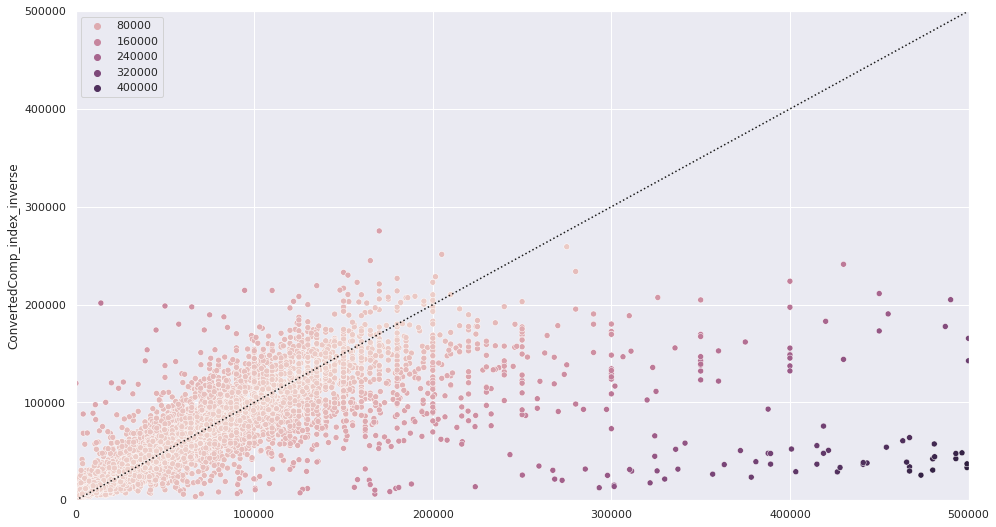

In [17]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')

plt.show()

In [18]:
results = run(exclude_columns=None, name="With Agg Features",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"],
             transform_target=True)

With Agg Features
Target Transformed


In [19]:
results

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals
LinearSVR,0.922463,21109.056117,461731.584440,0.474910,0.502809,0.356265,21967.291106,4.629315e+05,0.455892,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...",403,813 91000.0 21612 52942.0 10322 48...,813 111810.044578 21612 50887.132524 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
LassoCV,0.903141,21792.656985,459430.269936,0.473343,0.515334,0.342312,22466.923630,4.670552e+05,0.458503,"LassoCV(alphas=None, copy_X=True, cv=None, eps...",403,813 91000.0 21612 52942.0 10322 48...,813 116642.483753 21612 56817.256030 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RidgeCV,0.886552,21855.198985,461770.748814,0.474586,0.514040,0.341760,22557.151692,4.668552e+05,0.458681,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",403,813 91000.0 21612 52942.0 10322 48...,813 115794.001431 21612 56885.245897 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RandomForestRegressor,0.136518,9308.814430,319887.336899,0.841003,0.570094,0.343141,22652.421949,4.591280e+05,0.455306,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",403,813 91000.0 21612 52942.0 10322 48...,813 128095.503699 21612 85162.732704 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
LinearSVR,0.996856,22082.100777,460326.889793,0.475829,0.552177,0.337478,22788.900647,4.627596e+05,0.457982,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...",403,813 91000.0 21612 52942.0 10322 48...,813 108447.251978 21612 49919.357651 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
SVR,0.556721,15022.905101,426110.663644,0.703817,0.534820,0.327808,23050.904812,4.649975e+05,0.459646,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",403,813 91000.0 21612 52942.0 10322 48...,813 115647.946831 21612 60958.966972 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
LinearSVR,0.941157,25685.586398,469785.726501,0.385711,0.539706,0.275591,26069.667928,4.724274e+05,0.363625,"LinearSVR(C=10, dual=True, epsilon=0.0, fit_in...",403,813 91000.0 21612 52942.0 10322 48...,813 72536.190053 21612 49836.632141 10...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
DecisionTreeRegressor,0.000006,0.372912,120.179051,1.000000,1.014162,0.233320,37592.314197,1.498004e+06,-0.753502,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",403,813 91000.0 21612 52942.0 10322 48...,813 107441.805430 21612 68224.513299 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...


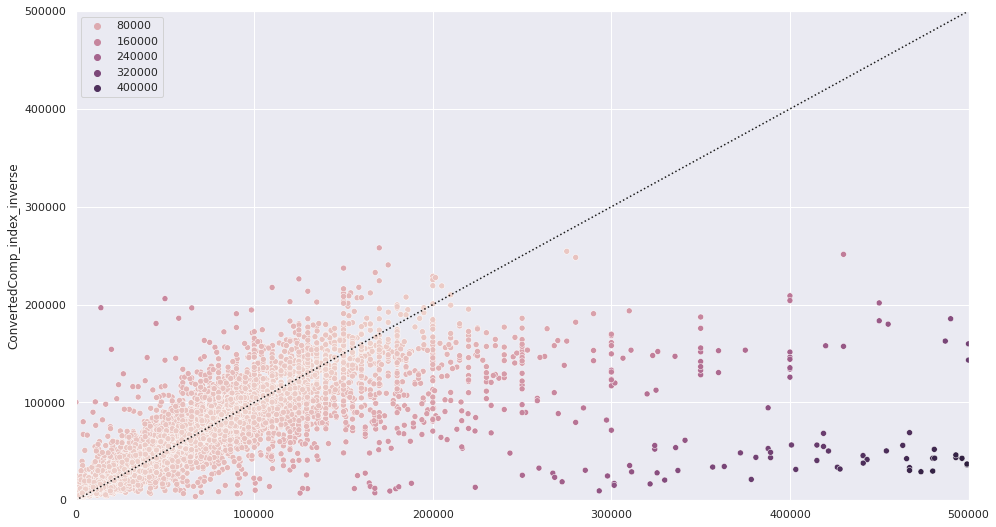

In [20]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')
plt.show()

In [21]:
results = run(exclude_columns=None, name="With Agg Features + relevant tech groups",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"],
             transform_target=True)

With Agg Features + relevant tech groups
Target Transformed


In [22]:
results

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals
LinearSVR,0.946317,21064.793430,461268.531332,0.479011,0.515561,0.356403,21957.508679,4.641285e+05,0.459971,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...",426,813 91000.0 21612 52942.0 10322 48...,813 103729.931118 21612 50323.143995 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
LinearSVR,0.926236,21291.843768,463183.640831,0.465886,0.508523,0.355021,22186.115102,4.652494e+05,0.444843,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...",426,813 91000.0 21612 52942.0 10322 48...,813 98057.479312 21612 48581.298138 10...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
LassoCV,0.907509,21731.431703,460794.263063,0.474608,0.522375,0.340517,22474.694967,4.673692e+05,0.458945,"LassoCV(alphas=None, copy_X=True, cv=None, eps...",426,813 91000.0 21612 52942.0 10322 48...,813 110203.324109 21612 57569.382052 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RidgeCV,0.890319,21791.903983,462766.318123,0.475985,0.522930,0.339412,22594.936308,4.671700e+05,0.458970,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",426,813 91000.0 21612 52942.0 10322 48...,813 108767.647992 21612 57834.021403 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RandomForestRegressor,0.137141,9301.760914,322957.180270,0.841363,0.567844,0.340655,22705.698021,4.569007e+05,0.454917,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",426,813 91000.0 21612 52942.0 10322 48...,813 127059.967263 21612 85407.079625 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
SVR,0.606458,15311.306156,433343.328050,0.685087,0.544272,0.328775,22985.734015,4.675016e+05,0.460097,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",426,813 91000.0 21612 52942.0 10322 48...,813 106496.076050 21612 62635.782187 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
LinearSVR,1.052950,27796.301915,469395.451891,0.332319,0.619149,0.259843,28498.385124,4.677258e+05,0.315955,"LinearSVR(C=10, dual=True, epsilon=0.0, fit_in...",426,813 91000.0 21612 52942.0 10322 48...,813 150873.876690 21612 59402.363315 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
DecisionTreeRegressor,0.000006,0.401191,120.179051,1.000000,0.968254,0.237464,38119.332367,1.498004e+06,-0.838157,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",426,813 91000.0 21612 52942.0 10322 48...,813 117014.367251 21612 89005.984157 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...


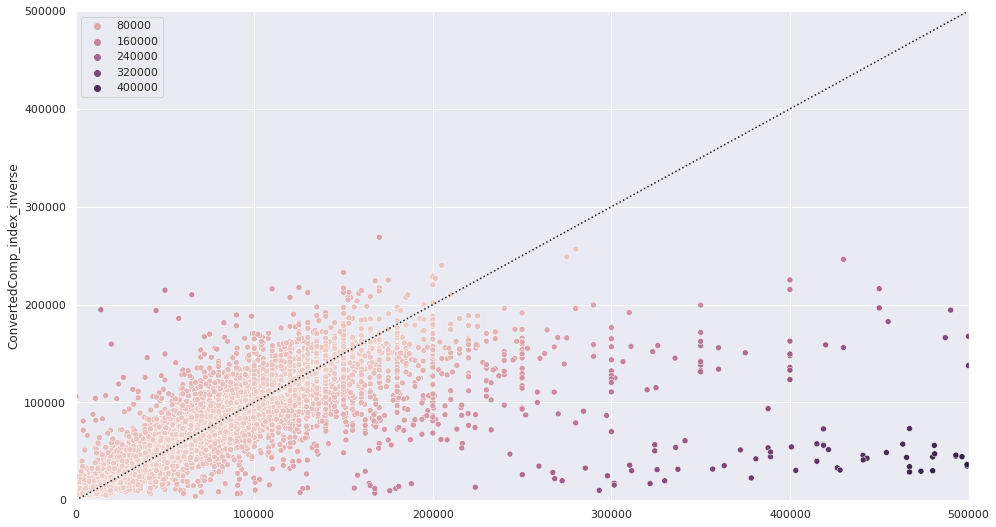

In [23]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')
plt.show()

In [24]:
experiment_list.sort_values("mape_test")

,mean_absolute_error_train,mape_train,mean_absolute_error_test,mape_test,index,num_feat,model_object,features
With Agg Features,21109.056117,0.922463,21967.291106,0.502809,LinearSVR,403,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DevType_Scientist', 'DevType_Developer..."
With Agg Features + relevant tech groups,21064.793430,0.946317,21957.508679,0.515561,LinearSVR,426,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DevType_Scientist', 'DevType_Developer..."
Initial Run w/o binning,20518.535061,0.953500,21579.029332,0.517983,SVR,567,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","Index(['Age', 'Age1stCode', 'YearsCode', 'Year..."
Initial Run,20600.658890,0.937717,21790.884868,0.521424,LinearSVR,603,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DatabaseDesireNextYear_MariaDB', ..."
"Initial Run w/o target transformation, binning",9214.592713,0.486664,25101.680641,0.832922,RandomForestRegressor,567,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...","Index(['Age', 'Age1stCode', 'YearsCode', 'Year..."


In [25]:
results = run(name="Initial Run + Feat Selection", feture_elimination_num_feat="auto", transform_target=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"])
results

Initial Run + Feat Selection
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals
RFE,0.845201,21641.490277,465684.244085,0.480488,0.534789,0.335405,22579.857267,469131.411324,0.461693,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",309,813 91000.0 21612 52942.0 10322 48...,813 134151.326762 21612 56228.263370 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
RFE,0.845317,21626.863174,466335.774151,0.481312,0.538779,0.335682,22597.221835,469432.075859,0.460867,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",461,813 91000.0 21612 52942.0 10322 48...,813 134169.479369 21612 58252.571361 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
RFE,0.845338,21625.527199,466280.069684,0.481341,0.538805,0.336234,22597.683422,469410.301793,0.460828,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",613,813 91000.0 21612 52942.0 10322 48...,813 134150.868023 21612 58293.513326 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
RFE,0.880616,21906.407782,462043.133201,0.472221,0.533171,0.336372,22639.653445,467427.237625,0.456341,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",157,813 91000.0 21612 52942.0 10322 48...,813 119057.078376 21612 56309.445903 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...
RFE,0.985355,25476.327788,456103.739438,0.377246,0.643661,0.282498,26332.564612,457524.894923,0.362393,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",5,813 91000.0 21612 52942.0 10322 48...,813 126314.034147 21612 73909.212153 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error ...


In [26]:
results = run(exclude_columns=None, name="With Agg Features + Feat Selection",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=False,
             feture_elimination_num_feat="auto",
             columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"],
             transform_target=True)
results

With Agg Features + Feat Selection
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals
RFE,0.886552,21855.198985,461770.748814,0.474586,0.514040,0.341760,22557.151692,466855.219454,0.458681,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",403,813 91000.0 21612 52942.0 10322 48...,813 115794.001431 21612 56885.245897 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RFE,0.886552,21855.198985,461770.748814,0.474586,0.514040,0.341760,22557.151692,466855.219454,0.458681,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",303,813 91000.0 21612 52942.0 10322 48...,813 115794.001431 21612 56885.245898 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RFE,0.887289,21887.880313,462309.884368,0.474264,0.515635,0.336511,22594.973313,466217.901729,0.458105,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",204,813 91000.0 21612 52942.0 10322 48...,813 118494.827877 21612 56536.737981 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RFE,0.907662,22086.599581,459587.976496,0.466682,0.527903,0.339550,22755.880438,468453.967987,0.450424,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",104,813 91000.0 21612 52942.0 10322 48...,813 113963.681823 21612 59843.255063 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RFE,1.028626,24962.036512,451102.241509,0.390828,0.623797,0.288714,25629.572055,456338.691383,0.380880,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",5,813 91000.0 21612 52942.0 10322 48...,813 133188.604784 21612 71571.885535 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...


In [27]:
results = run(exclude_columns=None, name="With Agg Features + relevant tech groups + Feat Selection",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=True,
             feture_elimination_num_feat="auto",
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"],
             transform_target=True)
results

With Agg Features + relevant tech groups + Feat Selection
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,below_15_prc_mape_ratio,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals
RFE,0.890319,21791.903983,462766.318123,0.475985,0.522930,0.339412,22594.936308,467170.006557,0.458970,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",320,813 91000.0 21612 52942.0 10322 48...,813 108767.647992 21612 57834.021403 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RFE,0.890319,21791.903983,462766.318123,0.475985,0.522930,0.339412,22594.936308,467170.006557,0.458970,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",426,813 91000.0 21612 52942.0 10322 48...,813 108767.647992 21612 57834.021403 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RFE,0.890985,21809.451787,462261.106331,0.475508,0.523745,0.338030,22614.801395,466223.423284,0.459063,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",215,813 91000.0 21612 52942.0 10322 48...,813 110845.745669 21612 56740.754542 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RFE,0.913488,22095.835679,460249.528932,0.466531,0.534078,0.338306,22749.482043,469046.743986,0.451427,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",110,813 91000.0 21612 52942.0 10322 48...,813 110846.897901 21612 56993.859488 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...
RFE,1.029726,25086.640661,448708.714089,0.384985,0.629570,0.288990,25590.052424,456761.252371,0.379419,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...",5,813 91000.0 21612 52942.0 10322 48...,813 124229.409834 21612 64956.366650 ...,"Index(['DevType_Scientist', 'DevType_Developer...",value abs_error abs_prc_error ...


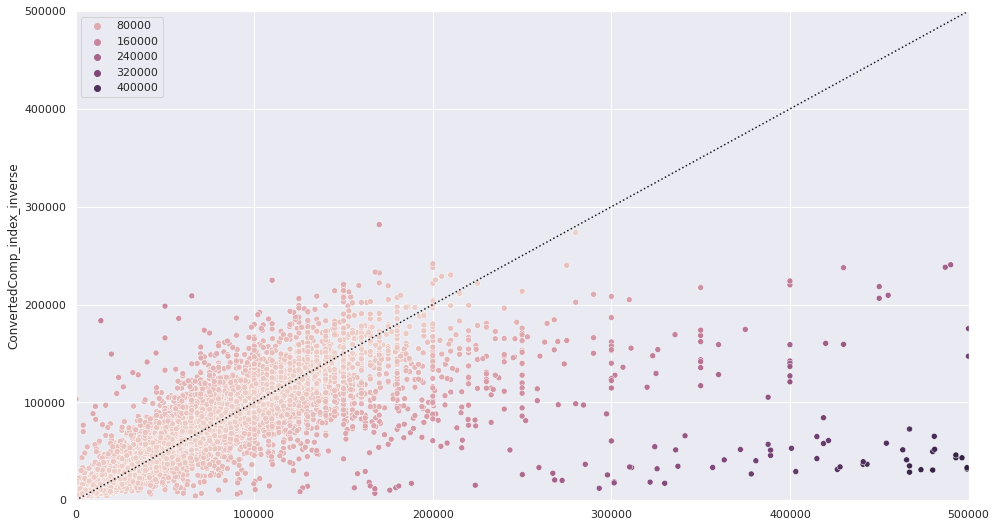

In [28]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')

plt.show()

In [29]:
experiment_list.sort_values("mape_test")

,mean_absolute_error_train,mape_train,mean_absolute_error_test,mape_test,index,num_feat,model_object,features
With Agg Features,21109.056117,0.922463,21967.291106,0.502809,LinearSVR,403,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DevType_Scientist', 'DevType_Developer..."
With Agg Features + Feat Selection,21855.198985,0.886552,22557.151692,0.514040,RFE,403,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...","Index(['DevType_Scientist', 'DevType_Developer..."
With Agg Features + relevant tech groups,21064.793430,0.946317,21957.508679,0.515561,LinearSVR,426,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DevType_Scientist', 'DevType_Developer..."
Initial Run w/o binning,20518.535061,0.953500,21579.029332,0.517983,SVR,567,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","Index(['Age', 'Age1stCode', 'YearsCode', 'Year..."
Initial Run,20600.658890,0.937717,21790.884868,0.521424,LinearSVR,603,"LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_i...","Index(['DatabaseDesireNextYear_MariaDB', ..."
With Agg Features + relevant tech groups + Feat Selection,21791.903983,0.890319,22594.936308,0.522930,RFE,320,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...","Index(['DevType_Scientist', 'DevType_Developer..."
Initial Run + Feat Selection,21641.490277,0.845201,22579.857267,0.534789,RFE,309,"RFE(estimator=RidgeCV(alphas=array([ 0.1, 1. ...","Index(['DatabaseDesireNextYear_MariaDB', ..."
"Initial Run w/o target transformation, binning",9214.592713,0.486664,25101.680641,0.832922,RandomForestRegressor,567,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...","Index(['Age', 'Age1stCode', 'YearsCode', 'Year..."


In [30]:
experiment_list.sort_values("mape_test").iloc[0,7].tolist()

['DevType_Scientist',
 'DevType_Developer, back-end',
 'DevType_Developer, desktop or enterprise applications',
 'DevType_Developer, front-end',
 'DevType_Developer, full-stack',
 'DevType_Developer, game or graphics',
 'DevType_Developer, mobile',
 'DevType_Academic researcher',
 'DevType_Database administrator',
 'DevType_Designer',
 'DevType_Developer, QA or test',
 'DevType_Engineer, data',
 'DevType_Data or business analyst',
 'DevType_Product manager',
 'DevType_Data scientist or machine learning specialist',
 'DevType_Developer, embedded applications or devices',
 'DevType_DevOps specialist',
 'DevType_System administrator',
 'DevType_Senior executive/VP',
 'DevType_Engineer, site reliability',
 'DevType_Engineering manager',
 'DevType_Educator',
 'DevType_Marketing or sales professional',
 'Ethnicity_White or of European descent',
 'Ethnicity_South Asian',
 'Ethnicity_East Asian',
 'Ethnicity_Biracial',
 'Ethnicity_Multiracial',
 'Ethnicity_Black or of African descent',
 'Ethni

In [31]:
a = data[data.ConvertedComp >= 400000].describe().T["mean"] - data.describe().T["mean"]

In [32]:
a.sort_values(ascending=False)

ConvertedComp                                                                                       374686.183094
YearsCode                                                                                                3.338187
YearsCodePro                                                                                             2.803602
Age                                                                                                      2.360490
OrgSize_10,000 or more employees                                                                         0.163729
Country_United States                                                                                    0.147930
JobFactors_Specific department or team I’d be working on                                                 0.134129
NEWJobHuntResearch_Publicly available financial information (e.g. Crunchbase)                            0.128179
NEWJobHuntResearch_Directly asking current or past employees at the company             